In [1]:
import sympy as sy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots
%matplotlib inline

from https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important

asume a normal distribution $q$, parametrized with $\theta$, so that $q_\theta(x) = \mathcal{N}(\theta, 1)$, we want to solve 

$$\text{min}_\theta \; \mathbb{E}_q[f(x)]\;\;\;\;\text{with}\;f(x)=x^2$$

we want the gradient of the above expression to help optimization

$$
\begin{align}
\nabla_\theta \mathbb{E}_q[f(x)] &= \nabla_\theta \int q_\theta(x) f(x) dx \\
&=  \int f(x) \frac{q\theta(x)}{q\theta(x)} \nabla_\theta q\theta(x) dx & (1)\\
&= \int q_\theta(x) f(x) \nabla_\theta \log q_\theta(x) dx & (2) \\
&= \mathbb{E}_q \big[ f(x) \nabla_\theta \log q_\theta(x) \big] & (3)
\end{align}
$$


In [36]:
x, t, m, s = sy.symbols(r"x \theta \mu \sigma")
pdf  = sy.exp(-0.5*((x-m)/s)**2)/(s*sy.sqrt(2*sy.pi))

f = (x+1)**2 
f = sy.sin(x)
fn = sy.lambdify(x, f, "numpy")

# check pdf
mn, sn = np.random.random(2)+1
pdfn = sy.lambdify(x, pdf.subs({m: mn, s: sn}), "numpy" )
pdfs = stats.norm(loc=mn, scale=sn).pdf
xr = np.linspace(-5,5,100)
assert np.allclose(pdfs(xr), pdfn(xr))

# set mu and sigma
sn = 2
pdf = pdf.subs({m: t, s: sn})

### a different perspective

- we have $x$ as as random variable, which is distributed according to $q_\theta$ in the following form:

    $$x \sim \mathcal{N}(\theta, 1)$$
    
  observe that different values of $\theta$ will produce different distributions of $x$
  
- we define $f(x)$, a transformation of $x$

- Question: **what is the distribution of $x$ after being trasformed by $f(x)$**


$$ f(x) \sim ??$$

let's observe how this transformation changes the distribution of $x$ under different values of $\theta$

2.997885334849868 1.0020214587027048
16.98713415430834 8.128621390705895
--
-0.003998544143708647 1.0015011879951703
1.9950235296235894 2.449080679954299
--
-0.9998853966277463 1.0020788566607586
1.0041620481004663 1.4211440261405126
--


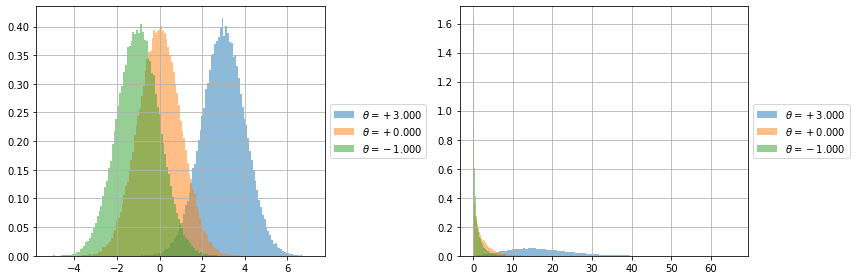

In [4]:
(ax0,_), (ax1,_) = list(subplots(2, usizex=6, usizey=4))
t_range = np.linspace(-2,2,5)
t_range = [3,0,-1]
for t in t_range:

    xv = np.random.normal(loc=t, scale=1, size=100000)
    fxv = fn(xv)

    ax0.hist(xv, bins=100, alpha=.5, density=True, label=f"$\\theta={t:+.3f}$")
    ax1.hist(fxv, bins=100, alpha=.5, density=True, label=f"$\\theta={t:+.3f}$")
    print (xv.mean(), xv.std())
    print (fxv.mean(), fxv.std())
    print ("--")
ax0.grid();
ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax1.grid();
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout()

In [43]:
fxv

array([-0.73510012, -0.39545724,  0.90235132, ...,  0.05934112,
       -0.43449653, -0.49851066])

### fix theta and compute the expectation


In [4]:
tn = np.random.random()*2
print (f"theta: {tn:.3f}")

theta: 1.286


#### integral of eq (2)


In [4]:
eint = ((pdf*f*sy.log(pdf).diff(t)).subs({t: tn}))
eint_fn = sy.lambdify(x, eint, "numpy")
quad(eint_fn, -np.inf, np.inf)

(2.1933443418094294, 9.512456843377874e-09)

#### gradient of expectation by sampling of eq (2)


In [5]:
N = 100

In [8]:
def compute_gradient(tn):
    qs = stats.norm(loc=tn, scale=1).rvs(N)
    expectation_fn = sy.lambdify(x, (f*sy.log(pdf).diff(t)).subs({t: tn}), "numpy")
    return expectation_fn(qs).mean()

compute_gradient(tn)

0.6325797115397438

#### let's compute the expectation for different values of $\theta$

In [9]:
def compute_expectation(tn):
    qs = stats.norm(loc=tn, scale=sn).rvs(N)
    expectation_fn = sy.lambdify(x, f, "numpy")
    return expectation_fn(qs).mean()


In [10]:
tr = np.linspace(-5,5,100)
exps = [compute_expectation(i) for i in pbar(tr)]

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


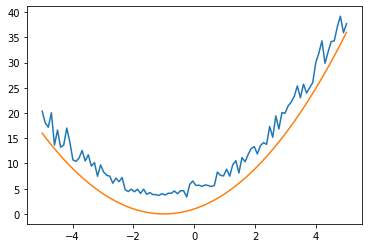

In [11]:
plt.plot(tr, exps)
plt.plot(tr, fn(tr))

#### let's do a small gradient descent to get the best $\theta$

$$\text{arg min}_\theta \; \mathbb{E}_q[f(x)]\;\;\;\;\text{with}\;f(x)=x^2$$


In [12]:
gtn = np.random.random()*5+5
learning_rate = 1e-1
lr_decay = 1e-2
for step in range(100):
    
    grad = compute_gradient(gtn)
    print (f"step {step:2d}: expectation for t={gtn:.3f} is {compute_expectation(gtn):.5f}, grad is {grad:.5f}, lr is {learning_rate:.5f}")

    gtn -= learning_rate * grad
    learning_rate *= (1-lr_decay)
    
print (f"step {step:2d}: expectation for t={gtn:.3f} is {compute_expectation(gtn):.5f}, grad is {grad:.5f}")


step  0: expectation for t=8.622 is 90.55475, grad is -0.73052, lr is 0.10000
step  1: expectation for t=8.695 is 104.89118, grad is 7.31724, lr is 0.09900
step  2: expectation for t=7.971 is 88.00208, grad is 2.60428, lr is 0.09801
step  3: expectation for t=7.716 is 78.80411, grad is 6.75094, lr is 0.09703
step  4: expectation for t=7.061 is 69.32051, grad is 3.44356, lr is 0.09606
step  5: expectation for t=6.730 is 65.69940, grad is 2.82635, lr is 0.09510
step  6: expectation for t=6.461 is 56.16534, grad is 4.48963, lr is 0.09415
step  7: expectation for t=6.038 is 50.89574, grad is 2.91046, lr is 0.09321
step  8: expectation for t=5.767 is 49.91219, grad is 2.81846, lr is 0.09227
step  9: expectation for t=5.507 is 48.61326, grad is 1.67204, lr is 0.09135
step 10: expectation for t=5.354 is 46.57619, grad is 2.51275, lr is 0.09044
step 11: expectation for t=5.127 is 40.03314, grad is 4.65023, lr is 0.08953
step 12: expectation for t=4.711 is 37.69529, grad is 1.33687, lr is 0.088

In [140]:
np.sin(4.74)

-0.9996188400141854

In [222]:
import numpy as np
N = 1000000
theta = 2.0
eps = np.random.randn(N)
x = theta + eps

grad1 = lambda x: np.sum(np.square(x)*(x-theta)) / x.size
grad2 = lambda eps: np.sum(2*(theta + eps)) / x.size

print (grad1(x))
print (grad2(eps))

4.006873903782586
3.9997908932376647


In [224]:
x = np.random.randn(N) + theta
eps = np.random.randn(N)
print (grad1(x))
print (grad2(eps))

3.9928147665797797
3.9972421264961464
